# Deep Q Learning

In Q-learning, the goal is to learn the action value function $Q$, which represents the expected return for taking an action $\mathbf{a}$ in a state $\mathbf{s}$ and following the optimal policy thereafter. For discrete state and action spaces, this is straightforward as we can use a table with $|\mathcal{S}|\times |\mathcal{A}|$ entries to store the action values. However, this approach becomes infeasible when dealing with continuous state spaces, such as in the case of a racing car or a moving robotic arm, where the state space can be infinitely large or unbounded.<br>

One possible solution is to discretize the continuous state space into a finite number of bins. But as the state space becomes larger or more complex, discretization can lead to exploding number of bins and a loss accuracy in representing the state space. To overcome these challenges, we can use function approximation techniques to parameterize the action value function, for example, using a neural network. This leads to a variant of Q-learning known as deep Q-learning. The update rule now becomes minimizing the mean square error

$$L(\phi) = (Q_{\phi}(\mathbf{s}_t, \mathbf{a}_t)- r(\mathbf{s}_t, \mathbf{a}_t) + \gamma \max_{\mathbf{a}}Q_{\phi}(\mathbf{s}_{t+1}, \mathbf{a}) )^2$$

Below, we implement a simple deep Q learning network that learns to solve the Cartpole task.

## Vanilla deep Q Learning 

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, device="cpu"):
        super(Policy, self).__init__()
        self.q_value = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, n_layers=1)
        self.action_space = torch.arange(action_dim)
        self.device = device

    def forward(self, state):
        state = torch.tensor(state).float().to(self.device)
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        return self.q_value(state)

    def q(self, state, action):
        action = torch.tensor(action)
        q_values = self.forward(state)
        return q_values[range(q_values.size(0)), action]

    def select_action(self, state, epsilon=0.0):
        if torch.rand(1) < epsilon:
            return self.action_space[torch.randint(0, self.action_space.size(0), (1,)).item()].item()
        else:
            with torch.no_grad():
                return self.forward(state).argmax(1).item()

In [ ]:
class QLearningAgentWithoutBuffer(Agent):
    """
    A Vanilla Deep Q-Learning agent
    """
    def __init__(self, env: any, policy: nn.Module, lr: float=1e-3, device: str="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

    def learn_episode(self, *param):
        max_steps, gamma, epsilon = param
        state = self.env.reset()
        episode_loss, episode_reward, step, done = 0, 0, 0, False
        while not done and step < max_steps:
            action = self.policy.select_action(state, epsilon=epsilon)
            next_state, reward, done, _ = self.env.step(action)
            episode_reward += reward
            self.optimizer.zero_grad()
            target = reward + gamma * (1 - done) * torch.max(self.policy(next_state), dim=1).values
            loss = (target.detach() - self.policy.q(state, action)).pow(2).mean()
            loss.backward()
            self.optimizer.step()
            state = next_state
            step += 1
            episode_loss += loss.item()
        return episode_loss, episode_reward

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(env.observation_space.shape[0], env.action_space.n)
agent_without_buffer = QLearningAgentWithoutBuffer(env, policy)
history = agent_without_buffer.learn(n_episodes=1000, epsilon=0.5, print_every=100)

## Deep Q Learning with experience replay

One assumption in the convergence results of supervised learning is that the data is independent and identically distributed (i.i.d.). However, this assumption does not hold in reinforcement learning because samples collected from the environment are often correlated, especially within the same trajectory or episode. This temporal correlation can lead to inefficiencies and poor convergence properties when training RL algorithms, particularly when using function approximation methods like neural networks.<br>

Also, each experience is typically used only once before being discarded. This contrasts with supervised learning, where each training example can be reused multiple times. The one-time use of experiences can lead to inefficient learning, as the algorithm may not fully exploit the information contained in each experience.<br>

To address the challenge of correlated data in reinforcement learning, Mnih et al. introduced the concept of experience replay buffers [1]. Instead of learning directly from consecutive transitions $\{(\mathbf{s}_i, \mathbf{a}_i, r_i, \mathbf{s}_{i+1})\}$, we store these transitions in a replay buffer. During training, we sample random batches from this buffer to update the network. This approach helps break the temporal correlation between data points, leading to a more stable and efficient training process.

Below, we implemented a simple replay buffer and will compare the effects of incorporating this replay buffer into training on the CartPole environment. The network architecture and hyperparameter setting is the same as the vanilla deep Q agent. In our experiment, we tried batch size of $8$ and $32$.

In [ ]:
class ReplayBuffer:
    """
    Replay buffer implementation
    When initialized, the buffer gets filled with transition samples
    """
    def __init__(self, env, maxlen=10000):
        self.env = env
        self.buffer = deque(maxlen=maxlen)
        self.maxlen = maxlen
        self.fill()

    def __len__(self):
        return len(self.buffer)

    def fill(self):
        while len(self.buffer) < self.maxlen:
            state = self.env.reset()
            done = False
            while not done:
                action = self.env.action_space.sample()
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.append((state, action, reward, next_state, done))
                state = next_state

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, n_samples):
        return zip(*random.sample(self.buffer, n_samples))

In [ ]:
class QLearningAgentWithBuffer(Agent):
    """
    A Deep Q-Learning agent with replay buffer
    """
    def __init__(self, env: any, policy: nn.Module, buffer_max_len: int=10000, lr: float=1e-3, device: str="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.buffer = ReplayBuffer(env, maxlen=buffer_max_len)
        self.device = device
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

    def learn_episode(self, batch_size: int=32, max_steps: int=1000, gamma: float=1, epsilon: float=0.1):
        self.policy.train()
        state, done, step, train_loss = self.env.reset(), False, 0, 0.0
        while not done and step < max_steps:
            ## 1. Add the samples into buffer
            action = self.policy.select_action(state, epsilon=epsilon)
            next_state, reward, done, _ = self.env.step(action)
            self.buffer.add(state, action, reward, next_state, done)

            ## 2. Sample a batch from the buffer for training
            self.optimizer.zero_grad()
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.buffer.sample(batch_size)
            reward_batch = torch.tensor(reward_batch).float().to(self.device)
            done_batch = torch.tensor(done_batch).int().to(self.device)
            target = reward_batch + gamma * (1 - done_batch) * torch.max(self.policy(next_state_batch), dim=1).values
            loss = (target.detach() - self.policy.q(state_batch, action_batch)).pow(2).mean()

            loss.backward()
            self.optimizer.step()
            state = next_state
            step += 1
            train_loss += loss.item()
        return train_loss

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(env.observation_space.shape[0], env.action_space.n)
agent_with_buffer = QLearningAgentWithBuffer(env, policy)
history = agent_with_buffer.learn(n_episodes=1000, batch_size=8, epsilon=0.5, print_every=100)

The results for training with no experience replay (NE), experience replay with a batch size of 8 (B8), and experience replay with a batch size of 32 (B32) are shown below. It is evident that experience replay significantly enhances the training process. Specifically, the agent learns more quickly with experience replay, and the reward curve exhibits less variance compared to training without experience replay. This demonstrates that experience replay not only accelerates learning but also stabilizes the training process.

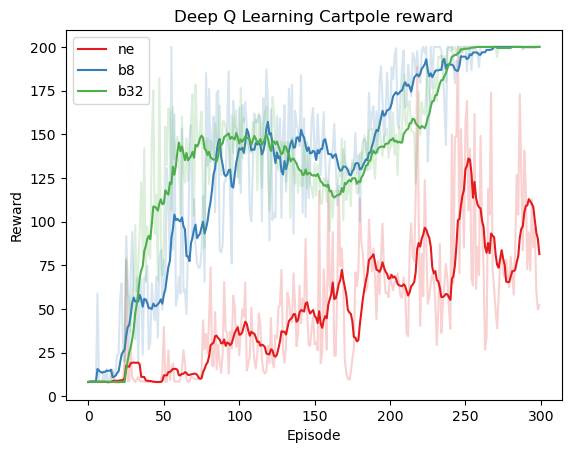

In [4]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/ValueBasedMethods/DQN/ne_reward_history.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/ValueBasedMethods/DQN/b8_reward_history.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/ValueBasedMethods/DQN/b32_reward_history.npy")]

names = ["ne", "b8", "b32"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward[:300], c=colors[i], alpha=0.2)
    plt.plot(smooth(reward[:300], 10), c=colors[i], label=names[i])
plt.title("Deep Q Learning Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/pdf/1312.5602